# Lagrangian-averaged vorticity deviation (LAVD)
In this example, we will compute the Lagrangian-averaged vorticity deviation (LAVD) field for a flat plate undergoing a 45-degree pitch-up maneuver. The original simluation of the flat plate was used by Wang and Eldredge 2012 (https://doi.org/10.1007/s00162-012-0279-5). The results are compared with Huang and Green 2016 (https://arc.aiaa.org/doi/10.2514/6.2016-2082). The theory behind LAVD can be found in Haller et al. 2016 (https://doi.org/10.1017/jfm.2016.151). A MATLAB package for computing LAVD and extracting coherent vortices can be found here (https://github.com/Hadjighasem/Lagrangian-Averaged-Vorticity-Deviation-LAVD).

In [2]:
using ILMPostProcessing
using ViscousFlow
using Plots
using Statistics

[ Info: Precompiling ILMPostProcessing [3d549a52-7b57-4935-b05e-d5b0ee0c7825] (cache misses: include_dependency fsize change (2), mismatched flags (4))


# Viscous Flow of Pitching Flat Plate
For faster compututation and testing purposes, the Reynolds number is set to 100 as opposed to 1000 in Huang's paper. The grid Re is also set to 4.0. If better resolution is desired, try grid Re = 3.0. The domain of interest is from x = -0.5 to x = 5.5, but it is set from x = -3.0 to x = 5.5 the velocity and vorticity fields ahead of the flat plate are required to compute LAVD.

 95.123571 seconds (75.59 M allocations: 88.346 GiB, 17.00% gc time, 0.13% compilation time)


[ Info: Saved animation to /Users/wuqiyuan/ILMPostProcessing.jl/examples/tmp.gif


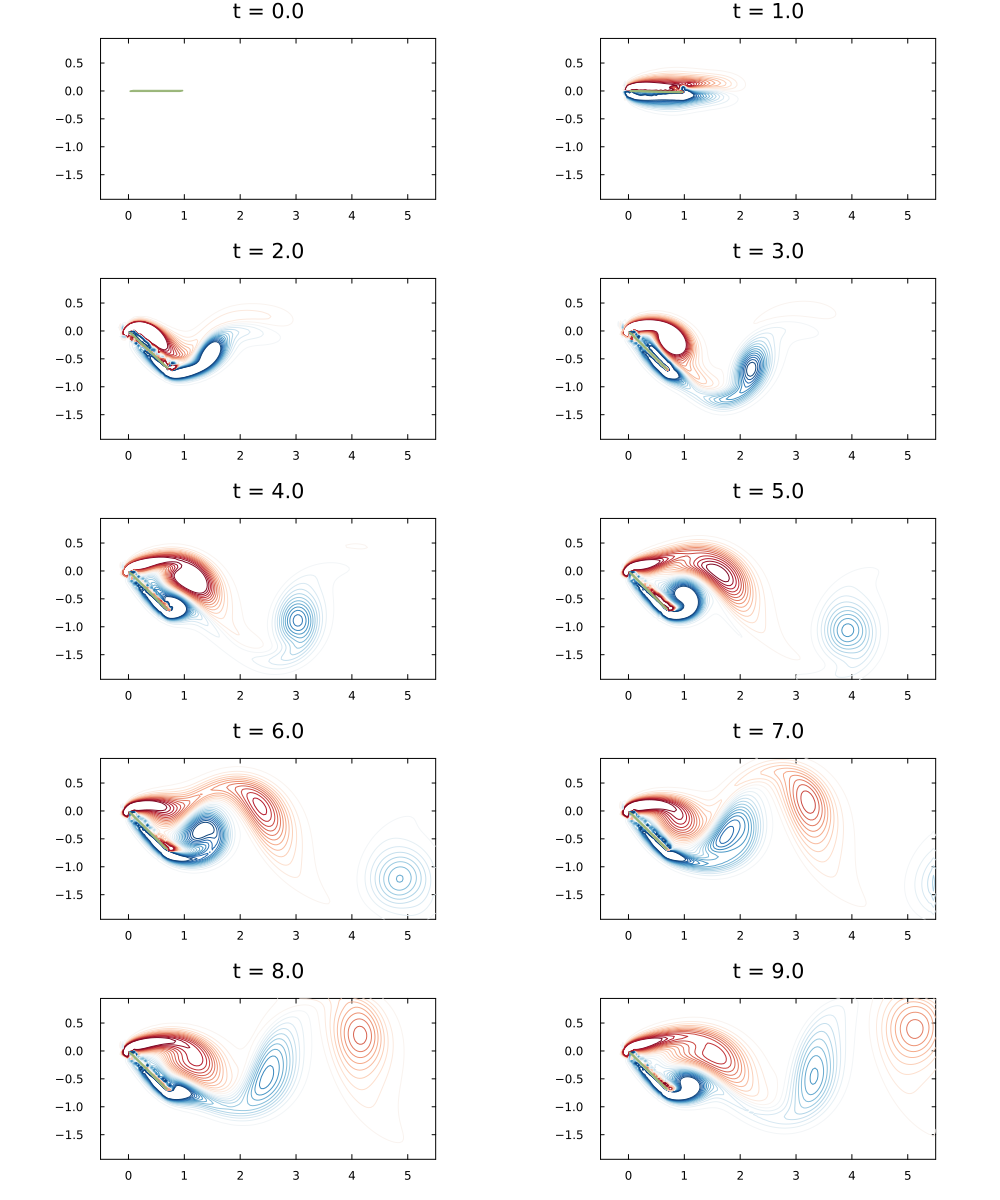

In [3]:
my_params = Dict()
my_params["Re"] = 100
my_params["grid Re"] = 4.0
my_params["freestream speed"] = 1.0
my_params["freestream angle"] = 0.0

xlim = (-3.0,5.5)
ylim = (-2.0,1.0)
g = setup_grid(xlim,ylim,my_params)

Δs = surface_point_spacing(g,my_params)
Lp = 1.0
body = Rectangle(Lp/2,0.023/2,Δs)
bl = BodyList([body])

parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # location of joint in inertial system
xpiv = [-0.5,0] # place center of motion at LE
Xc = MotionTransform(xpiv,0)

vel = 45pi/180  ## nominal ramp velocity
Δx = -45pi/180 ## change in position
t0 = 1.0 ## time of ramp start
k = SmoothRampDOF(vel,Δx,t0)

t = range(0,3,length=301)
plot(t,dof_position.(k.(t)),xlims=(0,Inf),label="x")

joint1 = Joint(RevoluteJoint,parent_body,Xp,child_body,Xc,[k])

m = RigidBodyMotion([joint1],bl)

x = init_motion_state(bl,m)
update_body!(bl,x,m)
plot(bl,xlim=xlim,ylim=ylim)

macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)

            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlim=$xlim,ylim=$ylim)
            end every 5
        end)
end

@animate_motion bl m 0.01 4 (-0.5, 5.5) ylim

function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity!(vsplus,x,base_cache,motions,t)
  return vsplus
end

function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity!(vsminus,x,base_cache,motions,t)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

sys = viscousflow_system(g,bl,phys_params=my_params,motions=m,bc=bcdict);
u0 = init_sol(sys)

Umax, imax, tmax, bmax = maxvelocity(u0,sys)
L = Lp
Re_eff = my_params["Re"]*Umax*L

tspan = (0.0,10.0)
integrator = init(u0,tspan,sys,alg=LiskaIFHERK(saddlesolver=CG))

step!(integrator)
@time step!(integrator,9.0)

sol = integrator.sol
plt = plot(layout = (5,2), size = (1000, 1200), legend=:false)
tsnap = 0.0:1.0:9.0
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,layers=false,title="t = $(round(t,digits=2))",clim=(-5,5),levels=range(-5,5,length=30),color = :RdBu, xlim = (-0.5, 5.5))
    plot!(plt[i],surfaces(sol,sys,t))
end
plt

# Compute LAVD

## Generate a Sequence of Velocity and Vorticity Fields
This step obtains the computed velocity and vorticity fields at a sequence of times, and stores them as a sequence of interpolatable
fields. This will greatly speed up how we compute the flow properties (i.e. vorticity) along trajectories.

In [4]:
t_start = 0.0
t_end = 8.5
dt = timestep(u0,sys)
tr = t_start:dt:t_end

velxy = velocity_xy(sol,sys,tr) # Vector of interpolatable velocities
velseq = VectorFieldSequence(tr,velxy); # Bundle together with the time array
vortxy = vorticity_xy(sol,sys,tr)
vortseq = ScalarFieldSequence(tr,vortxy);

## Generate Initial Conditions
Here, we generate a grid of initial locations from which to integrate trajectories.

In [5]:
X_MIN = -0.5
X_MAX = 5.5
Y_MIN = -2.0
Y_MAX = 1.0
dx = 0.04
lavdgrid = PhysicalGrid((X_MIN,X_MAX),(Y_MIN,Y_MAX),dx)
lavd_cache = SurfaceScalarCache(lavdgrid)
x0, y0 = x_grid(lavd_cache), y_grid(lavd_cache)

(Primal nodes in a (nx = 154, ny = 77) cell grid of type Float64 data
  Number of Primal nodes: (nx = 153, ny = 76), Primal nodes in a (nx = 154, ny = 77) cell grid of type Float64 data
  Number of Primal nodes: (nx = 153, ny = 76))

## Solve the IVP and Generate LAVD Fields

  1.763074 seconds (11.99 M allocations: 620.849 MiB, 3.30% gc time, 97.07% compilation time)


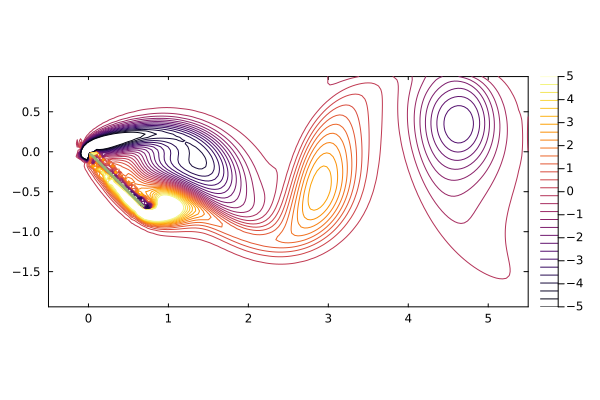

In [6]:
T = -2.0
t0 = 8.5
t1 = t0 + T

@time traj = compute_trajectory(velseq, (x0, y0), (t0, t1))

LAVD = similar(x0)
compute_LAVD!(LAVD, traj, X_MIN, Y_MIN, X_MAX, Y_MAX, vortseq)
plot(LAVD, lavd_cache, colorbar=true, levels  = 20)
plot!(surfaces(sol,sys,t0))
#savefig("lavd")

IVD = similar(x0)
compute_IVD!(IVD, traj, X_MIN, Y_MIN, X_MAX, Y_MAX, vortseq)
plot(IVD, lavd_cache, colorbar=true, levels = 20)
plot!(surfaces(sol,sys,t0))
#savefig("ivd")

plot(vorticity(sol, sys, t0), sys, layers = false,clim=(-5,5),levels=range(-5,5,length=30), colorbar=true, xlim=(-0.5, 5.5))
plot!(surfaces(sol,sys,t0))
#savefig("vorticity")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*